# Import Necessary Libraries

In [392]:
import pandas as pd
import gzip
import shutil
import seaborn as sns
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder, MaxAbsScaler
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer


from keras import models, layers 
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import  Adam

# Exploratory Data Analysis (EDA)

## Calendar Data - 2022

In [393]:
#Load raw calendar data from file
raw_calendar_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_calendar_2021.csv', compression='gzip')
raw_calendar_data

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
0,881707,2021-12-15,f,$93.00,$93.00,1,1125
1,910737,2021-12-15,t,$156.00,$156.00,2,1125
2,910737,2021-12-16,t,$156.00,$156.00,2,1125
3,910737,2021-12-17,f,$135.00,$135.00,2,1125
4,910737,2021-12-18,f,$135.00,$135.00,2,1125
...,...,...,...,...,...,...,...
958485,51875440,2022-12-10,t,$807.00,$807.00,5,365
958486,51875440,2022-12-11,t,$718.00,$718.00,5,365
958487,51875440,2022-12-12,t,$706.00,$706.00,5,365
958488,51875440,2022-12-13,t,$696.00,$696.00,5,365


In [394]:
#Check the info / types of data
raw_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   listing_id      958490 non-null  int64 
 1   date            958490 non-null  object
 2   available       958490 non-null  object
 3   price           958319 non-null  object
 4   adjusted_price  958319 non-null  object
 5   minimum_nights  958490 non-null  int64 
 6   maximum_nights  958490 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 51.2+ MB


In [395]:
#Convert date column to date-times type
mod_calendar_data = raw_calendar_data
mod_calendar_data['date'] = pd.to_datetime(raw_calendar_data['date'])

#Confirm the info / types of data
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  object        
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(3), object(3)
memory usage: 51.2+ MB


In [396]:
print(f"Earliest date of data set {raw_calendar_data['date'].min()}")
print(f"Latest date of data set {raw_calendar_data['date'].max()}")

Earliest date of data set 2021-12-15 00:00:00
Latest date of data set 2022-12-17 00:00:00


In [397]:
#Check Values of 'Available column'
mod_calendar_data['available'].value_counts()

t    532541
f    425949
Name: available, dtype: int64

In [398]:
#Replace the false and true values with 0 and 1
mod_calendar_data['available'] = mod_calendar_data['available'].replace(['f', 't'],[0, 1])

#Confirm available are now integers
mod_calendar_data['available'].value_counts()

1    532541
0    425949
Name: available, dtype: int64

In [399]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 958490 entries, 0 to 958489
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958490 non-null  int64         
 1   date            958490 non-null  datetime64[ns]
 2   available       958490 non-null  int64         
 3   price           958319 non-null  object        
 4   adjusted_price  958319 non-null  object        
 5   minimum_nights  958490 non-null  int64         
 6   maximum_nights  958490 non-null  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 51.2+ MB


In [400]:
mod_calendar_data['price'].value_counts()

$125.00      29854
$150.00      24356
$99.00       19492
$95.00       19240
$250.00      16814
             ...  
$1,391.00        1
$1,304.00        1
$1,711.00        1
$2,445.00        1
$1,322.00        1
Name: price, Length: 2100, dtype: int64

In [401]:
mod_calendar_data['price'].isna().sum()

171

In [402]:
mod_calendar_data['adjusted_price'].value_counts()

$125.00      28413
$150.00      24264
$99.00       19561
$95.00       19077
$250.00      16475
             ...  
$1,565.00        1
$1,166.00        1
$1,728.00        1
$1,688.00        1
$1,322.00        1
Name: adjusted_price, Length: 2097, dtype: int64

In [403]:
nan_cols = mod_calendar_data[mod_calendar_data['price'].isna()]
nan_cols['listing_id'].value_counts()

47732580    171
Name: listing_id, dtype: int64

In [404]:
bnb_to_drop = mod_calendar_data[(mod_calendar_data['listing_id'] == 47732580)].index
mod_calendar_data = mod_calendar_data.drop(bnb_to_drop)
mod_calendar_data['price'].isna().sum()

0

In [405]:
mod_calendar_data['price']

0          $93.00
1         $156.00
2         $156.00
3         $135.00
4         $135.00
           ...   
958485    $807.00
958486    $718.00
958487    $706.00
958488    $696.00
958489    $687.00
Name: price, Length: 958125, dtype: object

In [406]:
test_price_df = mod_calendar_data['price'].str.split(".", expand=True)
test_price_df = test_price_df.rename(columns = {0 : 'daily_price'})
test_price_df = test_price_df.drop(labels = [1], axis = 1)
mod_calendar_data = test_price_df.join(mod_calendar_data, how = 'left')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace(',', '')
mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].astype({'daily_price':'int'})
mod_calendar_data = mod_calendar_data.drop(labels = ['adjusted_price', 'price'], axis = 1)

id_to_move = mod_calendar_data.pop('listing_id')
mod_calendar_data.insert(0, 'listing_id', id_to_move)
mod_calendar_data

/var/folders/vj/wwng1wrx4433kjdgg3pdcmbc0000gn/T/ipykernel_3470/3964135494.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  mod_calendar_data['daily_price'] = mod_calendar_data['daily_price'].str.replace('$', '')


,listing_id,daily_price,date,available,minimum_nights,maximum_nights
0,881707,93,2021-12-15,0,1,1125
1,910737,156,2021-12-15,1,2,1125
2,910737,156,2021-12-16,1,2,1125
3,910737,135,2021-12-17,0,2,1125
4,910737,135,2021-12-18,0,2,1125
...,...,...,...,...,...,...
958485,51875440,807,2022-12-10,1,5,365
958486,51875440,718,2022-12-11,1,5,365
958487,51875440,706,2022-12-12,1,5,365
958488,51875440,696,2022-12-13,1,5,365


In [407]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   listing_id      958125 non-null  int64         
 1   daily_price     958125 non-null  int64         
 2   date            958125 non-null  datetime64[ns]
 3   available       958125 non-null  int64         
 4   minimum_nights  958125 non-null  int64         
 5   maximum_nights  958125 non-null  int64         
dtypes: datetime64[ns](1), int64(5)
memory usage: 83.4 MB


In [408]:
#For purposes of this project/the stakeholder, we will drop the adjusted avail, price, min nights, max nights
mod_calendar_data = mod_calendar_data.drop(['available', 'minimum_nights', 'maximum_nights'],
                                          axis = 1)

In [409]:
#Check all columns are integer types
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


In [410]:
# mod_calendar_data_id_avail = mod_calendar_data.groupby(['listing_id']).sum()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.reset_index()
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['price'], axis = 1)
# mod_calendar_data_id_avail['perc_year_avail'] = mod_calendar_data_id_avail['available'] / 365
# mod_calendar_data_id_avail = mod_calendar_data_id_avail.drop(['available'], axis = 1)
# mod_calendar_data_id_avail

In [411]:
# mod_calendar_data_id_avail.info()

## Listings Data - 2022

In [412]:
raw_listings_data = pd.read_csv('../Data/AirBnB/Asheville/2021/asheville_listings_2021.csv')
raw_listings_data.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,108061,https://www.airbnb.com/rooms/108061,20211215062309,2021-12-15,Walk to stores/parks/downtown. Fenced yard/Pet...,Walk to town in ten minutes! Monthly rental in...,"I love my neighborhood! Its friendly, easy-goi...",https://a0.muscache.com/pictures/41011975/0cdf...,320564,https://www.airbnb.com/users/show/320564,...,4.79,4.84,4.48,NaN,f,2,2,0,0,0.71
1,155305,https://www.airbnb.com/rooms/155305,20211215062309,2021-12-15,Cottage! BonPaul + Sharky's Hostel,<b>The space</b><br />Private cottage located ...,"We are within easy walk of pubs, breweries, mu...",https://a0.muscache.com/pictures/8880711/cf38d...,746673,https://www.airbnb.com/users/show/746673,...,4.76,4.93,4.53,NaN,t,7,1,2,4,2.75
2,156805,https://www.airbnb.com/rooms/156805,20211215062309,2021-12-15,"Private Room ""Ader"" at BPS Hostel",<b>The space</b><br />Private Rooms at Bon Pau...,"Easy walk to pubs, cafes, bakery, breweries, l...",https://a0.muscache.com/pictures/23447d55-fa7e...,746673,https://www.airbnb.com/users/show/746673,...,4.61,4.84,4.46,NaN,t,7,1,2,4,0.54
3,156926,https://www.airbnb.com/rooms/156926,20211215062309,2021-12-15,"Mixed Dorm ""Top Bunk #1"" at BPS Hostel",This is a top bunk in the mixed dorm room<br /...,NaN,https://a0.muscache.com/pictures/98f4e655-c4d6...,746673,https://www.airbnb.com/users/show/746673,...,4.80,4.78,4.78,NaN,t,7,1,2,4,2.36
4,160594,https://www.airbnb.com/rooms/160594,20211215062309,2021-12-15,Historic Grove Park,Come enjoy the beautiful Grove Park neighborho...,NaN,https://a0.muscache.com/pictures/92433837/d340...,769252,https://www.airbnb.com/users/show/769252,...,4.88,4.90,4.85,NaN,f,1,0,1,0,0.46


In [413]:
raw_listings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 74 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            2626 non-null   int64  
 1   listing_url                                   2626 non-null   object 
 2   scrape_id                                     2626 non-null   int64  
 3   last_scraped                                  2626 non-null   object 
 4   name                                          2626 non-null   object 
 5   description                                   2621 non-null   object 
 6   neighborhood_overview                         2040 non-null   object 
 7   picture_url                                   2626 non-null   object 
 8   host_id                                       2626 non-null   int64  
 9   host_url                                      2626 non-null   o

In [414]:
#Remove irrelevant review columns
mod_listing_data = raw_listings_data.drop(labels = ['review_scores_accuracy', 
                                                    'review_scores_cleanliness', 
                                                    'review_scores_checkin', 
                                                    'review_scores_communication', 
                                                    'review_scores_location',
                                                    'calendar_updated', 
                                                    'license'], axis = 1)

In [415]:
#Remove irrelevant host columns
mod_listing_data = mod_listing_data.drop(labels = ['host_name', 
                                                   'host_since', 
                                                   'host_location', 
                                                   'host_about', 
                                                   'host_response_time', 
                                                   'host_acceptance_rate',
                                                   'host_thumbnail_url', 
                                                   'host_picture_url', 
                                                   'host_neighbourhood', 
                                                   'host_listings_count', 
                                                   'host_total_listings_count', 
                                                   'host_verifications', 
                                                   'host_has_profile_pic',
                                                   'first_review',
                                                   'last_review'], axis = 1)

In [416]:
#Remove

mod_listing_data = mod_listing_data.drop(labels = ['scrape_id',
                                                  'last_scraped',
                                                  'neighbourhood_cleansed',
                                                  'neighbourhood_group_cleansed',
                                                  'property_type',
                                                  'bathrooms',
                                                  'price',
                                                   'minimum_minimum_nights',
                                                   'maximum_minimum_nights',
                                                   'minimum_maximum_nights',
                                                   'maximum_maximum_nights',
                                                   'minimum_nights_avg_ntm',
                                                   'maximum_nights_avg_ntm',
                                                   'has_availability',
                                                   'availability_30',
                                                   'availability_60',
                                                   'availability_90',
                                                   'availability_365',
                                                   'calendar_last_scraped',
                                                   'number_of_reviews_ltm',
                                                   'number_of_reviews_l30d',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calculated_host_listings_count_private_rooms',
                                                   'calculated_host_listings_count_shared_rooms',
                                                  'neighborhood_overview',
                                                  'reviews_per_month',
                                                  'review_scores_value',
                                                  'host_response_rate',
                                                  'description'], axis = 1)

In [417]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   neighbourhood           2041 non-null   object 
 9   latitude                2626 non-null   float64
 10  longitude               2626 non-null   float64
 11  room_type               2626 non-null   object 
 12  accommodates            2626 non-null   int64  
 13  bathrooms_text          2625 non-null   object 
 14  bedrooms                2463 non-null   

In [418]:
#Fill the missing neighborhood data with 'Asheville, North Carolina, United States'
mod_listing_data['neighbourhood'] = mod_listing_data['neighbourhood'].fillna('Asheville, North Carolina, United States')
mod_listing_data['neighbourhood'].isna().sum()

0

In [419]:
test_neighbor_df = mod_listing_data['neighbourhood'].str.split(",", expand=True)
test_neighbor_df = test_neighbor_df.rename(columns = {0 : 'neighborhood'})
test_neighbor_df = test_neighbor_df.drop(labels = [1, 2, 3, 4], axis = 1)
mod_listing_data = mod_listing_data.join(test_neighbor_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['neighbourhood'], axis = 1)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2626 entries, 0 to 2625
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2626 non-null   int64  
 1   listing_url             2626 non-null   object 
 2   name                    2626 non-null   object 
 3   picture_url             2626 non-null   object 
 4   host_id                 2626 non-null   int64  
 5   host_url                2626 non-null   object 
 6   host_is_superhost       2626 non-null   object 
 7   host_identity_verified  2626 non-null   object 
 8   latitude                2626 non-null   float64
 9   longitude               2626 non-null   float64
 10  room_type               2626 non-null   object 
 11  accommodates            2626 non-null   int64  
 12  bathrooms_text          2625 non-null   object 
 13  bedrooms                2463 non-null   float64
 14  beds                    2558 non-null   

In [420]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Ashville'],['Asheville'])

neigh_to_drop = mod_listing_data[(mod_listing_data['neighborhood'] == 'Leicester') | 
                                 (mod_listing_data['neighborhood'] == 'Swannanoa') | 
                                 (mod_listing_data['neighborhood'] == 'Avery Creek') | 
                                 (mod_listing_data['neighborhood'] == 'Fairview') |
                                 (mod_listing_data['neighborhood'] == 'Limestone') |
                                 (mod_listing_data['neighborhood'] == 'Biltmore Forest')].index
mod_listing_data = mod_listing_data.drop(neigh_to_drop)

In [421]:
mod_listing_data['neighborhood'] = mod_listing_data['neighborhood'].replace(['Asheville '], 'Asheville')

In [422]:
mod_listing_data['neighborhood'].value_counts()

Asheville    2323
Arden         131
Woodfin        62
Candler        54
Fletcher       47
Name: neighborhood, dtype: int64

In [423]:
#Remove rows with no bedrooms data
mod_listing_data = mod_listing_data.dropna(subset = ['bedrooms', 
                                                     'beds', 
                                                     'review_scores_rating', 
                                                     'bathrooms_text'], axis = 0)

In [424]:
mod_listing_data.isna().sum()

id                        0
listing_url               0
name                      0
picture_url               0
host_id                   0
host_url                  0
host_is_superhost         0
host_identity_verified    0
latitude                  0
longitude                 0
room_type                 0
accommodates              0
bathrooms_text            0
bedrooms                  0
beds                      0
amenities                 0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
instant_bookable          0
neighborhood              0
dtype: int64

In [425]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_is_superhost'] = mod_listing_data['host_is_superhost'].replace(['f', 't'],[0, 1])
mod_listing_data['host_is_superhost'].value_counts()

1    1703
0     566
Name: host_is_superhost, dtype: int64

In [426]:
#Replace the false and true values with 0 and 1
mod_listing_data['host_identity_verified'] = mod_listing_data['host_identity_verified'].replace(['f', 't'],[0, 1])
mod_listing_data['host_identity_verified'].value_counts()

1    1798
0     471
Name: host_identity_verified, dtype: int64

In [427]:
#Replace the false and true values with 0 and 1
mod_listing_data['instant_bookable'] = mod_listing_data['instant_bookable'].replace(['f', 't'],[0, 1])
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [428]:
mod_listing_data['neighborhood'].value_counts()

Asheville    2008
Arden         117
Woodfin        54
Candler        47
Fletcher       43
Name: neighborhood, dtype: int64

In [429]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [430]:
mod_listing_data['instant_bookable'].value_counts()

1    1322
0     947
Name: instant_bookable, dtype: int64

In [431]:
mod_listing_data['beds'].value_counts()

1.0     779
2.0     685
3.0     374
4.0     196
5.0      99
6.0      69
7.0      27
8.0      14
9.0       9
11.0      6
12.0      4
10.0      3
21.0      2
13.0      1
15.0      1
Name: beds, dtype: int64

In [432]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bathrooms_text          2269 non-null   object 
 13  bedrooms                2269 non-null   float64
 14  beds                    2269 non-null   

In [433]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [434]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [435]:
mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].replace(['Shared half-bath', 'Half-bath', 
                                                                                'Private half-bath'],
                                                                                 [0.5, 0.5, 0.5])

In [436]:
mod_listing_data['bathrooms_text'].isna().sum()

0

In [437]:
mod_listing_data['bathrooms_text'].value_counts()

1 bath              1122
2 baths              481
1 private bath       201
3 baths              102
2.5 baths            100
1.5 baths             92
1 shared bath         67
3.5 baths             32
4 baths               26
1.5 shared baths       8
4.5 baths              8
2 shared baths         7
5 baths                7
2.5 shared baths       6
6 baths                4
5.5 baths              3
0 baths                1
7 baths                1
8 baths                1
Name: bathrooms_text, dtype: int64

In [438]:
# mod_listing_data['bathrooms_text'] = mod_listing_data['bathrooms_text'].str.split(" ", n = 1, expand = True)

test_df = mod_listing_data['bathrooms_text'].str.split(" ", expand=True)
test_df = test_df.rename(columns = {0 : 'bathrooms'})
test_df = test_df.drop(labels = [1, 2], axis = 1)
mod_listing_data = mod_listing_data.join(test_df, how = 'outer')
mod_listing_data = mod_listing_data.drop(labels = ['bathrooms_text'], axis = 1)
mod_listing_data['bathrooms'] = mod_listing_data['bathrooms'].fillna(0.5)
mod_listing_data['bathrooms'] = pd.to_numeric(mod_listing_data['bathrooms'])
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  amenities               2269 non-null   

In [439]:
target_amenities = ['Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

In [440]:
def add_amenity_column(amenity_name):
    mod_listing_data[amenity_name] = mod_listing_data['amenities'].str.contains(amenity_name, regex=False)
    mod_listing_data[amenity_name] = mod_listing_data[amenity_name].replace([False, True],[0, 1])

In [441]:
add_amenity_column(target_amenities[0])
add_amenity_column(target_amenities[1])
add_amenity_column(target_amenities[2])
add_amenity_column(target_amenities[3])
add_amenity_column(target_amenities[4])
add_amenity_column(target_amenities[5])
add_amenity_column(target_amenities[6])

In [442]:
mod_listing_data = mod_listing_data.drop(['amenities'], axis = 1)

In [443]:
mod_listing_data['listing_id'] = mod_listing_data['id']
mod_listing_data = mod_listing_data.drop(['id'], axis = 1)
column_to_move = mod_listing_data.pop('listing_id')
mod_listing_data.insert(0, 'listing_id', column_to_move)
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

## Combine Calendar Data and Listings Data

In [444]:
mod_calendar_data

,listing_id,daily_price,date
0,881707,93,2021-12-15
1,910737,156,2021-12-15
2,910737,156,2021-12-16
3,910737,135,2021-12-17
4,910737,135,2021-12-18
...,...,...,...
958485,51875440,807,2022-12-10
958486,51875440,718,2022-12-11
958487,51875440,706,2022-12-12
958488,51875440,696,2022-12-13


In [445]:
mod_calendar_data['listing_id']

0           881707
1           910737
2           910737
3           910737
4           910737
            ...   
958485    51875440
958486    51875440
958487    51875440
958488    51875440
958489    51875440
Name: listing_id, Length: 958125, dtype: int64

In [446]:
print(mod_listing_data.columns)
mod_calendar_data.columns

Index(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
       'host_url', 'host_is_superhost', 'host_identity_verified', 'latitude',
       'longitude', 'room_type', 'accommodates', 'bedrooms', 'beds',
       'minimum_nights', 'maximum_nights', 'number_of_reviews',
       'review_scores_rating', 'instant_bookable', 'neighborhood', 'bathrooms',
       'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer',
       'Heating'],
      dtype='object')


Index(['listing_id', 'daily_price', 'date'], dtype='object')

In [447]:
mod_calendar_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 958125 entries, 0 to 958489
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   listing_id   958125 non-null  int64         
 1   daily_price  958125 non-null  int64         
 2   date         958125 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 61.5 MB


In [448]:
mod_listing_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2269 entries, 0 to 2618
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   listing_id              2269 non-null   int64  
 1   listing_url             2269 non-null   object 
 2   name                    2269 non-null   object 
 3   picture_url             2269 non-null   object 
 4   host_id                 2269 non-null   int64  
 5   host_url                2269 non-null   object 
 6   host_is_superhost       2269 non-null   int64  
 7   host_identity_verified  2269 non-null   int64  
 8   latitude                2269 non-null   float64
 9   longitude               2269 non-null   float64
 10  room_type               2269 non-null   object 
 11  accommodates            2269 non-null   int64  
 12  bedrooms                2269 non-null   float64
 13  beds                    2269 non-null   float64
 14  minimum_nights          2269 non-null   

### Drop Outliers

In [454]:
asheville_data = pd.merge(mod_listing_data, mod_calendar_data, how = 'left', on = 'listing_id')
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827821 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827821 non-null  int64         
 1   listing_url             827821 non-null  object        
 2   name                    827821 non-null  object        
 3   picture_url             827821 non-null  object        
 4   host_id                 827821 non-null  int64         
 5   host_url                827821 non-null  object        
 6   host_is_superhost       827821 non-null  int64         
 7   host_identity_verified  827821 non-null  int64         
 8   latitude                827821 non-null  float64       
 9   longitude               827821 non-null  float64       
 10  room_type               827821 non-null  object        
 11  accommodates            827821 non-null  int64         
 12  bedrooms                827821

In [457]:
asheville_data = asheville_data.dropna()

In [458]:
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 827820 entries, 0 to 827820
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              827820 non-null  int64         
 1   listing_url             827820 non-null  object        
 2   name                    827820 non-null  object        
 3   picture_url             827820 non-null  object        
 4   host_id                 827820 non-null  int64         
 5   host_url                827820 non-null  object        
 6   host_is_superhost       827820 non-null  int64         
 7   host_identity_verified  827820 non-null  int64         
 8   latitude                827820 non-null  float64       
 9   longitude               827820 non-null  float64       
 10  room_type               827820 non-null  object        
 11  accommodates            827820 non-null  int64         
 12  bedrooms                827820

In [459]:
asheville_data['bathrooms']

0         1.0
1         1.0
2         1.0
3         1.0
4         1.0
         ... 
827816    1.0
827817    1.0
827818    1.0
827819    1.0
827820    1.0
Name: bathrooms, Length: 827820, dtype: float64

In [460]:
asheville_data = asheville_data[asheville_data['bathrooms'] <= 6]
asheville_data = asheville_data[asheville_data['bathrooms'] >= 1]

asheville_data = asheville_data[asheville_data['bedrooms'] <= 6]
asheville_data = asheville_data[asheville_data['beds'] <= 11]
asheville_data = asheville_data[asheville_data['bathrooms'] <= 5]

asheville_data = asheville_data[asheville_data['room_type'] != 'Hotel room']
asheville_data = asheville_data[asheville_data['room_type'] != 'Shared room']

In [467]:
asheville_data = asheville_data.reset_index()
asheville_data = asheville_data.drop(['index'], axis = 1)

In [468]:
asheville_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815775 entries, 0 to 815774
Data columns (total 30 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   listing_id              815775 non-null  int64         
 1   listing_url             815775 non-null  object        
 2   name                    815775 non-null  object        
 3   picture_url             815775 non-null  object        
 4   host_id                 815775 non-null  int64         
 5   host_url                815775 non-null  object        
 6   host_is_superhost       815775 non-null  int64         
 7   host_identity_verified  815775 non-null  int64         
 8   latitude                815775 non-null  float64       
 9   longitude               815775 non-null  float64       
 10  room_type               815775 non-null  object        
 11  accommodates            815775 non-null  int64         
 12  bedrooms                815775

# Begin Modeling

## Baseline Model - Random Forest

In [469]:
asheville_modeling_data = asheville_data.drop(['listing_id', 'listing_url', 'name', 'picture_url', 'host_id',
                                              'host_url', 'host_identity_verified', 'latitude', 'longitude',
                                              'minimum_nights', 'maximum_nights', 'number_of_reviews',
                                              'instant_bookable', 'review_scores_rating'], axis = 1)
asheville_modeling_data.head()

,host_is_superhost,room_type,accommodates,bedrooms,beds,neighborhood,bathrooms,Air conditioning,Wifi,TV,Kitchen,Washer,Dryer,Heating,daily_price,date
0,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-15
1,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-16
2,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-17
3,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-18
4,0,Entire home/apt,2,1.0,1.0,Asheville,1.0,1,1,0,1,1,1,1,120.0,2021-12-19


In [472]:
asheville_modeling_data['neighborhood'].value_counts()

Asheville    720875
Arden         42705
Woodfin       19710
Candler       17155
Fletcher      15330
Name: neighborhood, dtype: int64

In [473]:
asheville_modeling_data['day_of_week'] = asheville_modeling_data['date'].dt.dayofweek
asheville_modeling_data['month'] = asheville_modeling_data['date'].dt.month
asheville_modeling_data = asheville_modeling_data.drop(['date'], axis = 1)
asheville_modeling_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 815775 entries, 0 to 815774
Data columns (total 17 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   host_is_superhost  815775 non-null  int64  
 1   room_type          815775 non-null  object 
 2   accommodates       815775 non-null  int64  
 3   bedrooms           815775 non-null  float64
 4   beds               815775 non-null  float64
 5   neighborhood       815775 non-null  object 
 6   bathrooms          815775 non-null  float64
 7   Air conditioning   815775 non-null  int64  
 8   Wifi               815775 non-null  int64  
 9   TV                 815775 non-null  int64  
 10  Kitchen            815775 non-null  int64  
 11  Washer             815775 non-null  int64  
 12  Dryer              815775 non-null  int64  
 13  Heating            815775 non-null  int64  
 14  daily_price        815775 non-null  float64
 15  day_of_week        815775 non-null  int64  
 16  mo

In [474]:
asheville_modeling_data['room_type'].value_counts()

Entire home/apt    697515
Private room       118260
Name: room_type, dtype: int64

In [475]:
asheville_modeling_data['Heating'].value_counts()

1    692405
0    123370
Name: Heating, dtype: int64

## Baseline Model - Random Forest

In [476]:
import time 

In [477]:
%%time

baseline_X = asheville_modeling_data.drop(['daily_price'], axis = 1)
baseline_y = asheville_modeling_data['daily_price']

baseline_X_train, baseline_X_test, baseline_y_train, baseline_y_test = train_test_split(baseline_X, 
                                                                                        baseline_y, 
                                                                                        test_size = 0.2)

baseline_numeric_cols = ['host_is_superhost', 'accommodates', 'bedrooms', 'beds', 'bathrooms', 
                         'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 'Dryer', 'Heating']

baseline_nominal_cols = ['neighborhood', 'room_type', 'day_of_week', 'month']

baseline_numeric_pipeline = Pipeline([('scaler', StandardScaler())])

baseline_nominal_pipeline = Pipeline([('ohe', OneHotEncoder(sparse = False))])

ct = ColumnTransformer([('nominalpipe', baseline_nominal_pipeline, baseline_nominal_cols ),
                        ('numpipe', baseline_numeric_pipeline, baseline_numeric_cols)])

baseline_final_pipe = Pipeline([('preprocess', ct),
                                ('model', RandomForestRegressor())])

baseline_final_pipe.fit(baseline_X_train, baseline_y_train)

CPU times: user 2min 31s, sys: 758 ms, total: 2min 32s
Wall time: 2min 32s


Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('nominalpipe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(sparse=False))]),
                                                  ['neighborhood', 'room_type',
                                                   'day_of_week', 'month']),
                                                 ('numpipe',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['host_is_superhost',
                                                   'accommodates', 'bedrooms',
                                                   'beds', 'bathrooms',
                                                   'Air conditioning', 'Wifi',
                                                   'TV', 'Kitchen', 'Washer',
                                                   'Dryer', 'Heating'])])),
                ('model', RandomForestRegressor())])

0.8086167109719568
0.7662536859046953


<AxesSubplot: xlabel='daily_price'>

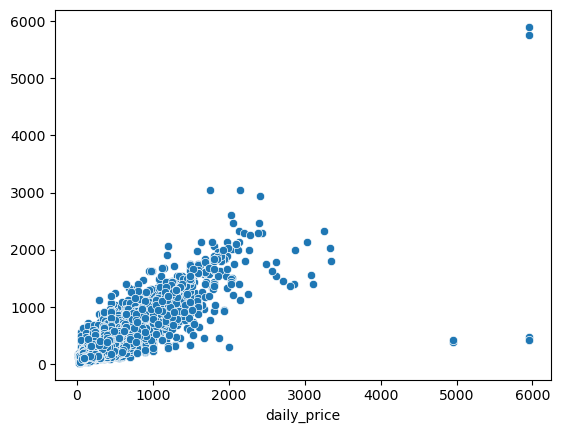

In [478]:
print(baseline_final_pipe.score(baseline_X_train, baseline_y_train))
print(baseline_final_pipe.score(baseline_X_test, baseline_y_test))

baseline_preds = baseline_final_pipe.predict(baseline_X_test)
sns.scatterplot(y = baseline_preds, x = baseline_y_test)

## Model 2 - Neural Network

In [479]:
#Neural Network

In [480]:
model2_cat_cols = asheville_modeling_data[['neighborhood', 'room_type', 'day_of_week', 'month']]
model2_cat_cols

,neighborhood,room_type,day_of_week,month
0,Asheville,Entire home/apt,2,12
1,Asheville,Entire home/apt,3,12
2,Asheville,Entire home/apt,4,12
3,Asheville,Entire home/apt,5,12
4,Asheville,Entire home/apt,6,12
...,...,...,...,...
815770,Asheville,Entire home/apt,5,12
815771,Asheville,Entire home/apt,6,12
815772,Asheville,Entire home/apt,0,12
815773,Asheville,Entire home/apt,1,12


In [481]:
#One hot encode the categorical columns
model2_sklearn = asheville_modeling_data
model2_cat = model2_sklearn[['neighborhood', 'room_type', 'day_of_week', 'month']]

ohe = OneHotEncoder(drop="first", sparse=False)
ohe.fit(model2_cat)

model2_cat_ohe = pd.DataFrame(data = ohe.transform(model2_cat),
                              columns = ohe.get_feature_names_out())
model2_cat_ohe

,neighborhood_Asheville,neighborhood_Candler,neighborhood_Fletcher,neighborhood_Woodfin,room_type_Private room,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815770,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
815771,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
815772,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
815773,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [483]:
#Merge the one hot encoded dataframe and the numeric columns
model2_numeric = asheville_modeling_data[['daily_price', 'host_is_superhost', 'accommodates', 'bedrooms', 'beds', 
                                          'bathrooms', 'Air conditioning', 'Wifi', 'TV', 'Kitchen', 'Washer', 
                                          'Dryer', 'Heating']]

model2_comb_ohe = model2_numeric.join(model2_cat_ohe, how = 'left')
model2_comb_ohe


,daily_price,host_is_superhost,accommodates,bedrooms,beds,bathrooms,Air conditioning,Wifi,TV,Kitchen,...,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12
0,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,120.0,0,2,1.0,1.0,1.0,1,1,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815770,165.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
815771,150.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
815772,150.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
815773,150.0,1,3,1.0,1.0,1.0,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [484]:
model2_X = model2_comb_ohe.drop(['daily_price'], axis = 1)
model2_y = model2_comb_ohe['daily_price']

model2_X_train, model2_X_test, model2_y_train, model2_y_test = train_test_split(model2_X, 
                                                                                model2_y, 
                                                                                test_size = 0.15)

model2_X_train, model2_X_val, model2_y_train, model2_y_val = train_test_split(model2_X_train, 
                                                                              model2_y_train,
                                                                              test_size = 0.12)

In [ ]:
#Consider adding a decaying learning rate

In [485]:
#Instantiate a Regularizer
reg = l2(3e-3)

model2_nn = models.Sequential()
model2_nn.add(layers.Dense(34, activation = 'relu', kernel_regularizer = reg, input_shape=(34, 1)))
model2_nn.add(layers.Dense(1))

#Create an opt variable which is set to the learning rate to be used, we will use 0.0002
opt = Adam(learning_rate = 0.0002)

#Add an early stopping mechanism which will stop fitting the model based on the minimum validation loss, a minimum
    #delta of le-8, and a patience of 10
es = EarlyStopping(monitor = 'mse', mode = 'min', min_delta = 1e-8, patience = 10)

#Set the random seed to 42 for reproducibility
np.random.seed(42)

#Compile the model and utilize the 'opt' variable, 
model2_nn.compile(optimizer = opt,
                  loss = 'mse',
                  metrics = ['mse', 'mae'])

#Create a new _histoire variable containing the fit model
model2_nn_histoire = model2_nn.fit(model2_X_train.values,
                                   model2_y_train.values,
                                   callbacks = [es],
                                   epochs = 50,
                                   batch_size = 500,
                                   validation_data = (model2_X_val.values, model2_y_val.values))

Epoch 1/50
   1/1221 [..............................] - ETA: 5:16 - loss: 64225.6367 - mse: 64225.6289 - mae: 195.0535

2022-12-19 16:28:22.174067: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1221/1221 [==============================] - ETA: 0s - loss: 66286.7812 - mse: 66286.7031 - mae: 195.8363

2022-12-19 16:28:41.217722: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1221/1221 [==============================] - 20s 16ms/step - loss: 66286.7812 - mse: 66286.7031 - mae: 195.8363 - val_loss: 64720.1953 - val_mse: 64720.1719 - val_mae: 192.9872
Epoch 2/50
1221/1221 [==============================] - 20s 17ms/step - loss: 63360.7266 - mse: 63360.7188 - mae: 188.0661 - val_loss: 60928.2773 - val_mse: 60928.2422 - val_mae: 182.6929
Epoch 3/50
1221/1221 [==============================] - 21s 17ms/step - loss: 59054.7305 - mse: 59054.7031 - mae: 176.0862 - val_loss: 56255.2930 - val_mse: 56255.2148 - val_mae: 169.4335
Epoch 4/50
1221/1221 [==============================] - 20s 17ms/step - loss: 54275.6758 - mse: 54275.5977 - mae: 162.2776 - val_loss: 51467.6953 - val_mse: 51467.5977 - val_mae: 155.3968
Epoch 5/50
1221/1221 [==============================] - 20s 17ms/step - loss: 49670.2734 - mse: 49670.1289 - mae: 148.5646 - val_loss: 47107.8750 - val_mse: 47107.7461 - val_mae: 142.2512
Epoch 6/50
1221/1221 [==============================] - 21s 17ms/step -

In [ ]:
#One Hot Encode
#Scale

In [ ]:
#text = input()`